Going to use the supercritical Hopf bifurcation neuronal model...
Going to use the Euler-Maruyama Integrator...
Going to use Functional Connectivity (FC)...
Going to use Sliding Windows Functional Connectivity Dynamics (swFCD)...
Going to use Phase-Interaction Matrix...
Going to use Phase Functional Connectivity Dynamics (phFCD)...
SCnorm.shape=(78, 78)
filtPowSpetraMultipleSubjects: subject 0 (of 19)
filtPowSpetraMultipleSubjects: subject 1 (of 19)
filtPowSpetraMultipleSubjects: subject 2 (of 19)
filtPowSpetraMultipleSubjects: subject 3 (of 19)
filtPowSpetraMultipleSubjects: subject 4 (of 19)
filtPowSpetraMultipleSubjects: subject 5 (of 19)
filtPowSpetraMultipleSubjects: subject 6 (of 19)
filtPowSpetraMultipleSubjects: subject 7 (of 19)
filtPowSpetraMultipleSubjects: subject 8 (of 19)
filtPowSpetraMultipleSubjects: subject 9 (of 19)
filtPowSpetraMultipleSubjects: subject 10 (of 19)
filtPowSpetraMultipleSubjects: subject 11 (of 19)
filtPowSpetraMultipleSubjects: subject 12 (of 19)
filt

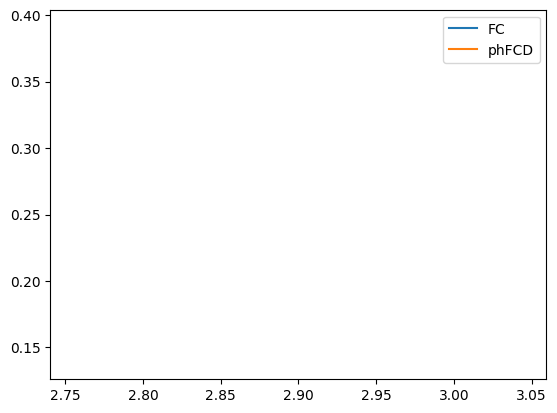

In [1]:
# Load all the packages needed for analyses
import sys
import numpy as np
import scipy.io as sio
from numba import jit
import matplotlib.pyplot as plt

# Set up Hopf as our model 
import WholeBrain.Models.supHopf as Hopf
from WholeBrain.simulate_SimOnly import Tmaxneuronal
Hopf.initialValue = 0.1
neuronalModel = Hopf

# Set up our integrator
import WholeBrain.Integrator_EulerMaruyama as myIntegrator
integrator = myIntegrator
integrator.neuronalModel = neuronalModel
integrator.verbose = False
integrator.clamping = False

# Set up the integration parameters
dt = 5e-5
# tmax is equal to the number of timepoints: 193
tmax= 193
ds = 1e-4
Tmaxneuronal = int((tmax+dt))

import WholeBrain.simulate_SimOnly as simulateBOLD
simulateBOLD.warmUp = True
simulateBOLD.integrator = integrator
simulateBOLD.warmUpFactor = 606./2000.

# Set up the code to obtain the variables we want to maximize similarity to empirical FC
import WholeBrain.Observables.FC as FC
import WholeBrain.Observables.swFCD as swFCD
import WholeBrain.Observables.phFCD as phFCD
import WholeBrain.Optimizers.ParmSeep as ParmSeep
ParmSeep.simulateBOLD = simulateBOLD
ParmSeep.integrator = integrator
ParmSeep.verbose = True


# set BOLD filter settings
import WholeBrain.Utils.filteredPowerSpectralDensity as filtPowSpectr
import WholeBrain.BOLDFilters as BOLDfilters

# These filters are applied in the filtPowSpectr function that we use to extract the intrinsic frequencies of each region.
# They are also applied to process the FC and swFCD and phFCD, but you can set the corresponding parameter to False later on. 0.04-0.07 Hz common to extract intrinsic frequencies
BOLDfilters.flp = 0.04
BOLDfilters.fhi = 0.07
BOLDfilters.TR = 3.0


# Get the list of names of all regions in the AAL atlas. This is needed to get the right indices, to then filter the FC
import csv
# This is a sublist of label of the cortical regions that were included in the paper by Demirtas et al. - AAL atlas (78 regions, excluding infratentorial and deep)
with open ('/home/riccardo/ADNI_Hopf/Utils/aal_regions_included.csv', newline='') as g:
    new_reader = csv.reader(g)
    included_regions = list(new_reader)
g.close()

# Get the AAL atlas labels
import nilearn.datasets as datasets
aal = datasets.fetch_atlas_aal()
labels = np.array(aal.labels)
# create an array with the indices of each label (note that these are not the label number from the nifti image)
indices = np.array([i for i in enumerate(labels)])
FC_regions_index = np.isin(labels, included_regions)
# filter the indices that we want based on the position 
FC_78_regions_aal_atlas = indices[FC_regions_index]
filter_FC = np.array([int(i) for i in FC_78_regions_aal_atlas[:,0]])

# Set file path.
x_path = '/home/riccardo/ADNI_Hopf/Utils/'

# Load structural connectivity matrix and use it as parameter in Hopf model
xfile = 'SCmatrices88healthy.mat' 
M = sio.loadmat(x_path + xfile); 
mat = M['SCmatrices']
# averaging the SC among subjects
mat0 = np.mean(mat,axis = 0)
x_mat0 = mat0[filter_FC]
new_mat0 = x_mat0.T[filter_FC]
SCnorm = new_mat0 * 0.2 / new_mat0.max() 
np.fill_diagonal(SCnorm,0)
print('SCnorm.shape={}'.format(new_mat0.shape))    
Hopf.setParms({'SC':SCnorm})


# ------------------------------------------------
# Configure and compute Simulation for fixed a = -0.02 and fitting G to HC to find the best G
# ------------------------------------------------
# Load the list of names for all MCI
list_HC = np.load('/home/riccardo/ADNI_Hopf/Results/subject_list_timeseries_MCI.npy')
# Load the timeseries for MCI
timeseries = np.load('/home/riccardo/ADNI_Hopf/Results/timeseries_MCI.npy')

nsubjects, nNodes, Tmax = timeseries.shape
all_fMRI = {s: d for s,d in enumerate(timeseries)} 
subjectName = ''
conditionToStudy='hc'
mode = 'homogeneous'  # homogeneous/heterogeneous
# Since we aleardy filtered the data in the previous step from Nilearn, we aren't going to filter them again. Otherwise, a possible alternative, could be to add another
# BOLDfilters to actually re-set the filters after the f_diff was extracted and before the call to the simulation. phFCD is set to True as it depends on the choice of the bandwidth to calculate the phases.
distanceSettings = {'FC': (FC, False), 'phFCD': (phFCD, True)}

simulateBOLD.TR = 3.  # Recording interval: 1 sample every 3 seconds
simulateBOLD.dt = 0.1 * simulateBOLD.TR / 2.
simulateBOLD.Tmax = Tmax  # This is the length, in seconds
simulateBOLD.dtt = simulateBOLD.TR  # We are not using milliseconds
simulateBOLD.t_min = 10 * simulateBOLD.TR
# simulateBOLD.recomputeTmaxneuronal() <- do not update Tmaxneuronal this way!
# simulateBOLD.warmUpFactor = 6.
simulateBOLD.Tmaxneuronal = (Tmax-1) * simulateBOLD.TR + 30
integrator.ds = simulateBOLD.TR  # record every TR millisecond

base_a_value = -0.02
# Hopf.beta = 0.01
f_diff = filtPowSpectr.filtPowSpetraMultipleSubjects(timeseries, TR=3.)  # should be baseline_group_ts .. or baseling_group[0].reshape((1,52,193))
f_diff[np.where(f_diff == 0)] = np.mean(f_diff[np.where(f_diff != 0)])  # f_diff(find(f_diff==0))=mean(f_diff(find(f_diff~=0)))

Hopf.setParms({'a': base_a_value})
Hopf.omega = 2 * np.pi * f_diff

print("ADHopf Setup done!")


warmUp = True
warmUpFactor = 10.

def computeSubjectSimulation():
    # integrator.neuronalModel.SC = C
    # integrator.initBookkeeping(N, Tmaxneuronal)
    if warmUp:
        currObsVars = integrator.warmUpAndSimulate(dt, Tmaxneuronal, TWarmUp=Tmaxneuronal/warmUpFactor)
    else:
        currObsVars = integrator.simulate(dt, Tmaxneuronal)
    # currObsVars = integrator.returnBookkeeping()  # curr_xn, curr_rn
    neuro_act = currObsVars[:,1,:]  # curr_rn
    return neuro_act
    
outFilePath = '/home/riccardo/ADNI_Hopf/Results/G_fitted_to_HC-minimalWMH/baseline_homogeneous_model_on_MCI/'

Gs = [2.9]

def fittingPipeline_homogeneous(all_fMRI,
                    distanceSettings,  # This is a dictionary of {name: (distance module, apply filters bool)}
                    gs):
    print("\n\n###################################################################")
    print("# Fitting with ParmSeep")
    print("###################################################################\n")
    # Now, optimize all we (G) values: determine optimal G to work with
    gParms = [{'we': g} for g in Gs]
    fitting = ParmSeep.distanceForAll_Parms(all_fMRI,
                                            Gs, 
                                            gParms,
                                            NumSimSubjects=len(all_fMRI),
                                            distanceSettings=distanceSettings,
                                            parmLabel='evaluating_best_G_',
                                            outFilePath=outFilePath)

    optimal = {sd: distanceSettings[sd][0].findMinMax(fitting[sd]) for sd in distanceSettings}
    return optimal, fitting

best_parameters, fitting = fittingPipeline_homogeneous(all_fMRI=all_fMRI, distanceSettings=distanceSettings, gs=Gs)

import matplotlib.pyplot as plt

for ds in distanceSettings:
          plt.plot(Gs, fitting[ds], label = ds)
          plt.legend()
          optimValDist = distanceSettings[ds][0].findMinMax(fitting[ds])
          parmPos = [a for a in np.nditer(Gs)][optimValDist[1]]
          print(f"# Optimal {ds} =     {optimValDist[0]} @ {np.round(parmPos, decimals=3)}")
plt.savefig(outFilePath + '/initial_exploration_plot.png')
